In [64]:
import numpy as np
import pandas as pd
from scipy.linalg import block_diag
import matplotlib.pyplot as plt

In [65]:
data = "../data/robot_data.csv"

In [66]:
df = pd.read_csv(data,header=None, names=['wheel_l','wheel_r','beta_l','beta_r','alpha', 'i', 'j'])

In [67]:
i_filter = 1
j_filter = 0

In [68]:
filtered = df[(df.i == i_filter) & (df.j == j_filter)].reset_index()
filtered

,index,wheel_l,wheel_r,beta_l,beta_r,alpha,i,j
0,184,5.045506,8.647794,-0.017502,0.021673,-0.030077,1.0,0.0
1,189,5.693804,9.232234,-0.016203,0.022134,-0.027398,1.0,0.0
2,194,6.831158,9.513143,-0.012312,0.015879,-0.016583,1.0,0.0
3,253,5.048041,8.647728,-0.017783,0.021551,-0.029797,1.0,0.0
4,258,5.695350,9.231703,-0.016133,0.022359,-0.026944,1.0,0.0
...,...,...,...,...,...,...,...,...
243,8253,5.045590,8.647789,-0.017542,0.021673,-0.029820,1.0,0.0
244,8258,5.693855,9.232214,-0.016282,0.022085,-0.027155,1.0,0.0
245,8263,6.831182,9.513110,-0.012468,0.015787,-0.016580,1.0,0.0
246,8302,5.045590,8.647789,-0.017735,0.021752,-0.029941,1.0,0.0


In [69]:
class Robot():
    def __init__(self, data) -> None:
        self.data = data
   

In [70]:
filtered.beta_l.size/4

62.0

In [71]:
robots = [Robot(filtered[i*64:(i+1)*64]) for i in range(4)]

In [72]:
def local_first_estimate(data):
    # Example data
    omega_l = data.wheel_l.values
    omega_r = data.wheel_r.values
    beta_l = data.beta_l.values
    beta_r = data.beta_r.values
    alpha = data.alpha.values
    Y = np.column_stack((beta_l, beta_r, alpha))

    # Initial OLS regression to get residuals
    X = np.column_stack((np.ones(len(omega_l)), omega_l, omega_r))
    theta_hat_ols = np.linalg.inv(X.T @ X) @ (X.T @ Y)
    y_hat_ols = X @ theta_hat_ols
    residuals_ols = Y - y_hat_ols

    # Estimate weights as the inverse of the squared residuals
    weights_l = 1 / (residuals_ols[:, 0] ** 2 + 1e-10) 
    weights_r = 1 / (residuals_ols[:, 1] ** 2 + 1e-10) 
    weights_alpha = 1 / (residuals_ols[:, 2] ** 2 + 1e-10) 

    # Create individual diagonal weight matrices for each output
    W_l = np.diag(weights_l)
    W_r = np.diag(weights_r)
    W_alpha = np.diag(weights_alpha)

    # Combine these into a block diagonal matrix
    W = block_diag(W_l, W_r, W_alpha)

    # Expand X to match the block diagonal structure
    X_expanded = np.kron(np.eye(3), X)  # Kronecker product to create the expanded X matrix

    F_0 = X_expanded.T @ W @ X_expanded
    a_0 = X_expanded.T @ W @ Y.flatten(order='F')
    # Now compute WLS using the expanded X and Y
    XTWX_inv = np.linalg.inv(F_0)
    XTWy = a_0
    beta_hat_wls_flat = XTWX_inv @ XTWy

    # Reshape the result back to the original coefficient shape
    beta_hat_wls = beta_hat_wls_flat.reshape(3, -1).T
    
    print("WLS Estimated coefficients:", beta_hat_wls)
    return F_0, a_0, beta_hat_wls


In [73]:
msg = {}

for i, robot in enumerate(robots):
    robot.F, robot.a, robot.beta_hat_wls = local_first_estimate(robot.data)
    msg[f"tractor{i}"] = {"F": robot.F, "a": robot.a}

WLS Estimated coefficients: [[-0.02404083 -0.025467   -0.02034025]
 [ 0.00358469 -0.00826205  0.01100351]
 [-0.00135245  0.01026842 -0.00752044]]
WLS Estimated coefficients: [[-0.02226486 -0.02419864 -0.01904477]
 [ 0.0037274  -0.00813587  0.01106296]
 [-0.00164185  0.01004372 -0.00770034]]
WLS Estimated coefficients: [[-0.02394782 -0.02610377 -0.0208913 ]
 [ 0.0036081  -0.00827125  0.01102178]
 [-0.00137896  0.0103396  -0.00747498]]
WLS Estimated coefficients: [[-0.02243562 -0.02401089 -0.02092856]
 [ 0.00368905 -0.0081597   0.01095163]
 [-0.00159698  0.01004011 -0.00742025]]


In [74]:
def global_estimate(msg):

    sum_F = np.zeros((9,9))
    sum_a = np.zeros((9,))

    for i in msg.keys():
        sum_F += msg[i]["F"]
        sum_a += msg[i]["a"]

    beta_hat_wls_global = np.linalg.inv(sum_F) @ sum_a
    
    return beta_hat_wls_global.reshape(3, -1).T

In [75]:
beta_hat_wls_global = global_estimate(msg)

In [76]:
beta_hat_wls_global

array([[-0.0232205 , -0.02514792, -0.02010254],
       [ 0.00365267, -0.00821765,  0.01101279],
       [-0.00148776,  0.01020179, -0.00755223]])

In [77]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Example data
omega_l = filtered.wheel_l.values
omega_r = filtered.wheel_r.values
beta_l = filtered.beta_l.values
beta_r = filtered.beta_r.values
alpha = filtered.alpha.values

# Extract coefficients from WLS estimation
theta_0_l, theta_1_l, theta_2_l = beta_hat_wls_global[:, 0]  # Coefficients for beta_l
theta_0_r, theta_1_r, theta_2_r = beta_hat_wls_global[:, 1]  # Coefficients for beta_r
theta_0_alpha, theta_1_alpha, theta_2_alpha = beta_hat_wls_global[:, 2]  # Coefficients for alpha

# Create a grid of values for omega_l and omega_r
omega_l_grid, omega_r_grid = np.meshgrid(np.linspace(omega_l.min(), omega_l.max(), 100),
                                         np.linspace(omega_r.min(), omega_r.max(), 100))

# Calculate the corresponding beta_l, beta_r, and alpha values on the grid
beta_l_grid = theta_0_l + theta_1_l * omega_l_grid + theta_2_l * omega_r_grid
beta_r_grid = theta_0_r + theta_1_r * omega_l_grid + theta_2_r * omega_r_grid
alpha_grid = theta_0_alpha + theta_1_alpha * omega_l_grid + theta_2_alpha * omega_r_grid


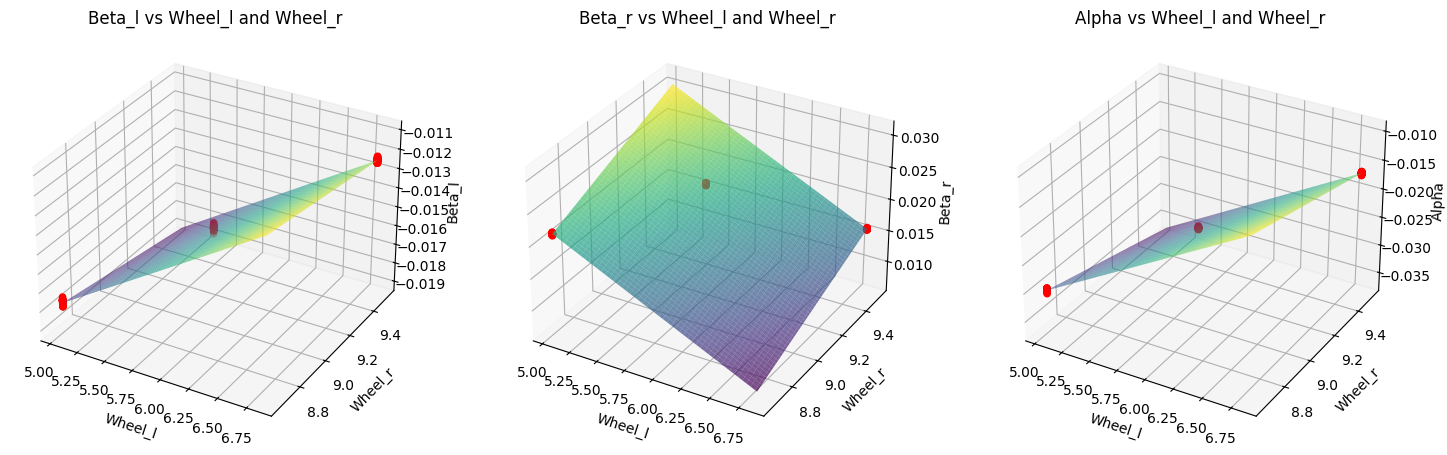

In [78]:
fig = plt.figure(figsize=(18, 6))

# Beta_l surface
ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(omega_l_grid, omega_r_grid, beta_l_grid, cmap=cm.viridis, alpha=0.7)
ax.scatter(omega_l, omega_r, beta_l, color='red')  # Original data points
ax.set_title('Beta_l vs Wheel_l and Wheel_r')
ax.set_xlabel('Wheel_l')
ax.set_ylabel('Wheel_r')
ax.set_zlabel('Beta_l')

# Beta_r surface
ax = fig.add_subplot(132, projection='3d')
ax.plot_surface(omega_l_grid, omega_r_grid, beta_r_grid, cmap=cm.viridis, alpha=0.7)
ax.scatter(omega_l, omega_r, beta_r, color='red')  # Original data points
ax.set_title('Beta_r vs Wheel_l and Wheel_r')
ax.set_xlabel('Wheel_l')
ax.set_ylabel('Wheel_r')
ax.set_zlabel('Beta_r')

# Alpha surface
ax = fig.add_subplot(133, projection='3d')
ax.plot_surface(omega_l_grid, omega_r_grid, alpha_grid, cmap=cm.viridis, alpha=0.7)
ax.scatter(omega_l, omega_r, alpha, color='red')  # Original data points
ax.set_title('Alpha vs Wheel_l and Wheel_r')
ax.set_xlabel('Wheel_l')
ax.set_ylabel('Wheel_r')
ax.set_zlabel('Alpha')

plt.show()
